# Generate plots for README

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import causalpy as cp

/tmp/ipykernel_23170/1899605088.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 42
rng = np.random.default_rng(seed)
image_path = "../_static/"

## ANCOVA

In [ ]:
df = cp.load_data("anova1")

### PyMC version

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


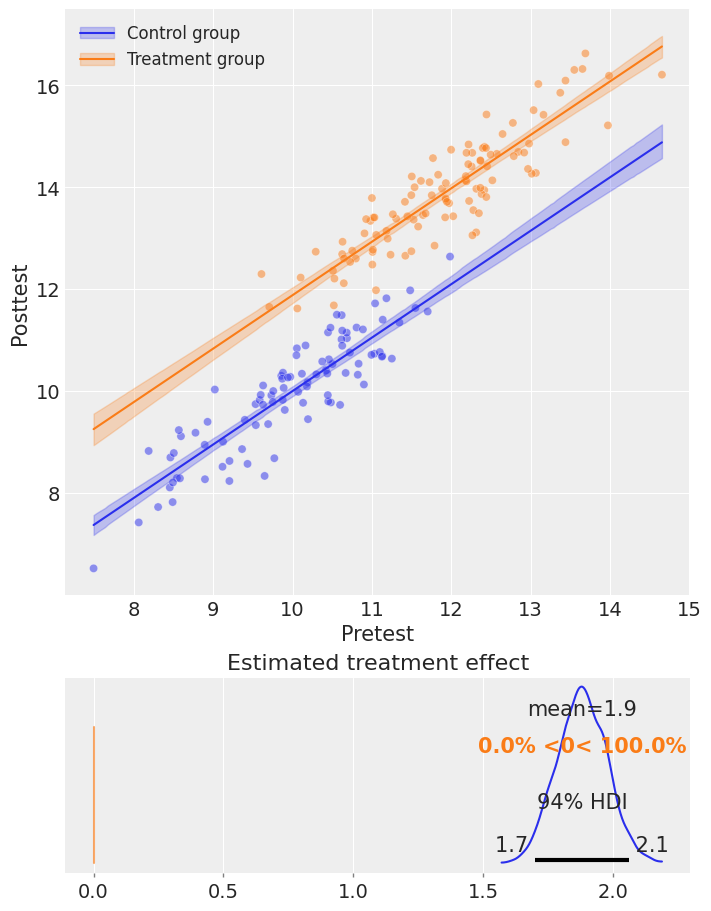

In [ ]:
result = cp.pymc_experiments.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    pretreatment_variable_name="pre",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)
result.plot()
plt.savefig(image_path + "anova_pymc.svg", bbox_inches="tight", pad_inches=0.1)

## Difference in differences

In [4]:
df = cp.load_data("did")

### PyMC version

In [5]:
result = cp.pymc_experiments.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group + t + group:post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    treated=1,
    untreated=0,
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


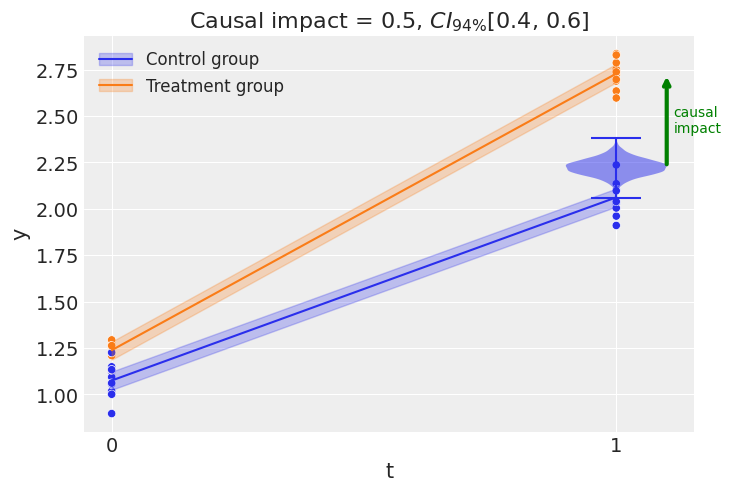

In [6]:
fig, ax = result.plot()
plt.savefig(
    image_path + "difference_in_differences_pymc.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1) + inhomogeneous part.

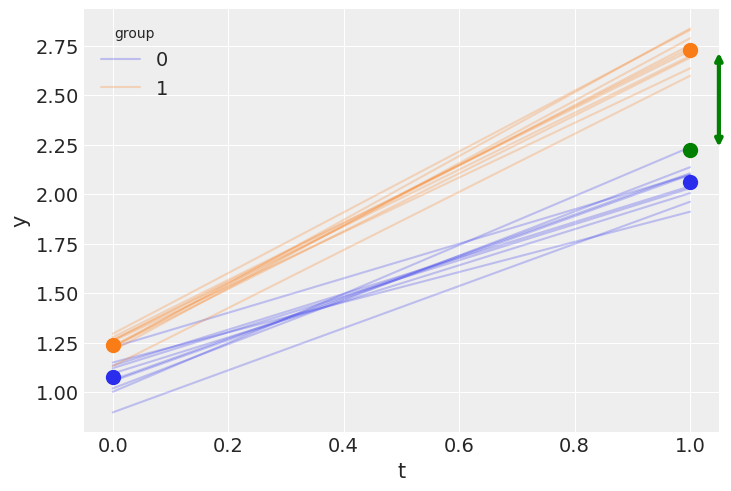

In [7]:
# Scikit-learn version
result = cp.skl_experiments.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    treated=1,
    untreated=0,
    model=LinearRegression(),
)
fig, ax = result.plot()
plt.savefig(
    image_path + "difference_in_differences_skl.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

## Regression discontinuity

In [8]:
df = cp.load_data("rd")

### PyMC version

In [9]:
result = cp.pymc_experiments.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


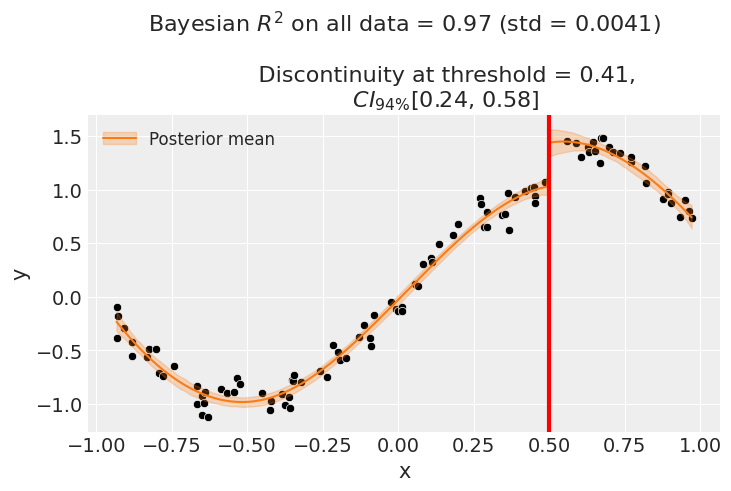

In [10]:
fig, ax = result.plot()
plt.savefig(
    image_path + "regression_discontinuity_pymc.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

### Scikit-learn version

In [12]:
result = cp.skl_experiments.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
)

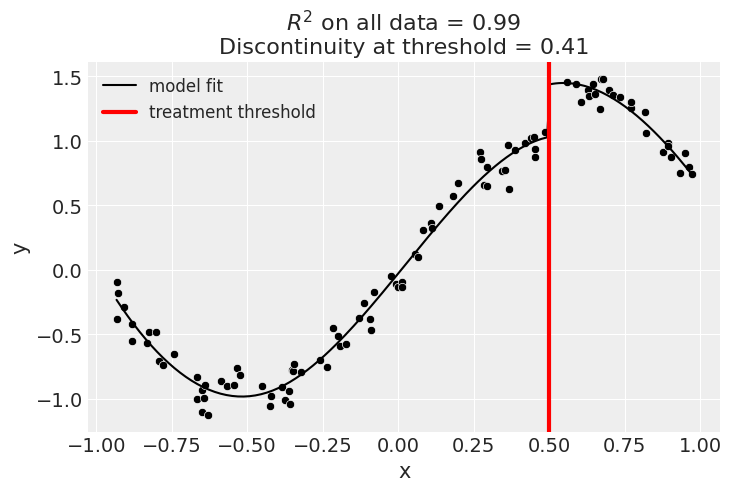

In [13]:
fig, ax = result.plot();

In [14]:
plt.savefig(
    image_path + "regression_discontinuity_skl.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

<Figure size 720x480 with 0 Axes>

## Regression kink design

In [15]:
def f(x, beta, kink):
    return (
        beta[0]
        + beta[1] * x
        + beta[2] * x**2
        + beta[3] * (x - kink) * (x >= kink)
        + beta[4] * (x - kink) ** 2 * (x >= kink)
    )


def generate_data(beta, kink, sigma=0.05, N=50):
    if beta is None:
        beta = rng.random(5)
    x = rng.uniform(-1, 1, N)
    y = f(x, beta, kink) + rng.normal(0, sigma, N)
    df = pd.DataFrame({"x": x, "y": y, "treated": x >= kink})
    return df


kink = 0.5
# linear function with gradient change of 2 at kink point
beta = [0, -1, 0, 2, 0]
sigma = 0.05
df = generate_data(beta, kink, sigma=sigma)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


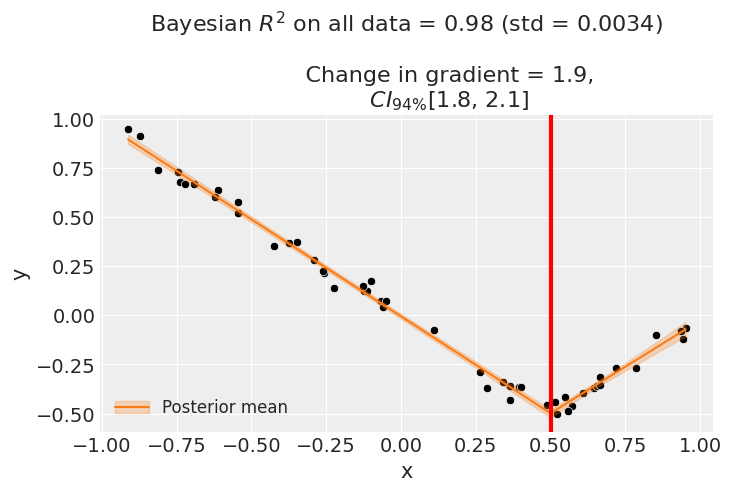

In [16]:
result = cp.pymc_experiments.RegressionKink(
    df,
    formula=f"y ~ 1 + x + I((x-{kink})*treated)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
    epsilon=0.1,
)

fig, ax = result.plot()
plt.savefig(
    image_path + "regression_kink_pymc.svg",
    bbox_inches="tight",
    pad_inches=0.1,
)

## Synthetic control

In [17]:
df = cp.load_data("sc")
treatment_time = 70

### PyMC version

In [18]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


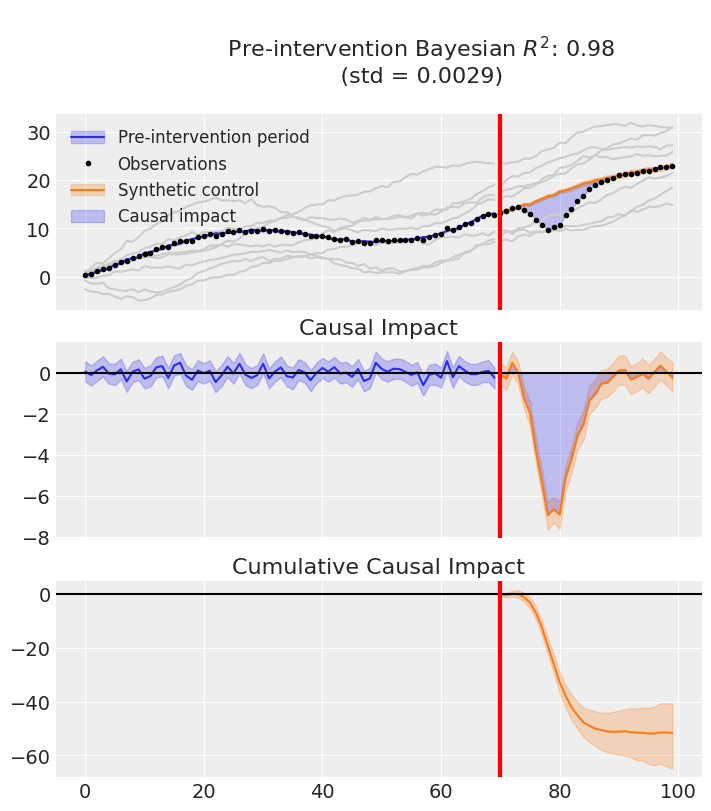

In [19]:
fig, ax = result.plot(plot_predictors=True)
plt.savefig(
    image_path + "synthetic_control_pymc.svg", bbox_inches="tight", pad_inches=0.1
)

### Scikit-learn version

In [20]:
result = cp.skl_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.skl_models.WeightedProportion(),
)

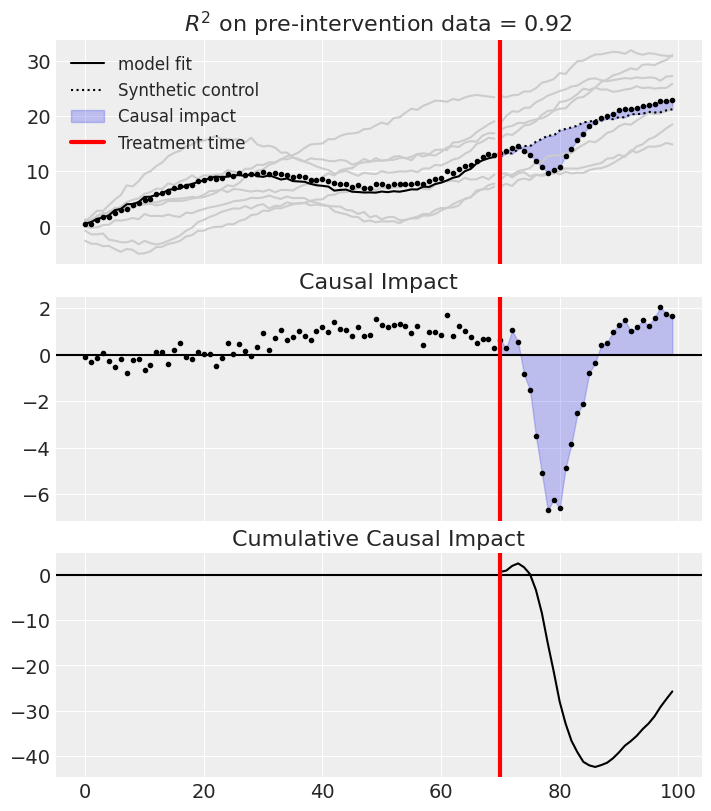

In [21]:
fig, ax = result.plot(plot_predictors=True)
plt.savefig(
    image_path + "synthetic_control_skl.svg", 
    bbox_inches="tight", 
    pad_inches=0.1
)

## Interrupted time series

In [3]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)
treatment_time = pd.to_datetime("2020-01-01")

### PyMC version

In [ ]:
result = cp.pymc_experiments.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


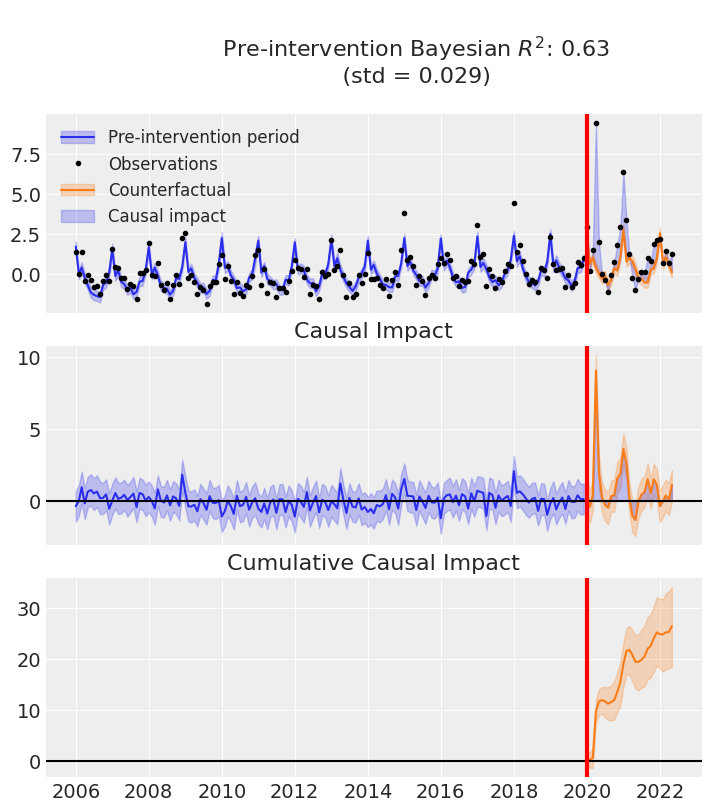

In [ ]:
fig, ax = result.plot()
plt.savefig(
    image_path + "interrupted_time_series_pymc.svg", bbox_inches="tight", pad_inches=0.1
)

### Scikit-learn version

In [6]:
result = cp.skl_experiments.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)",
    model=LinearRegression(),
)

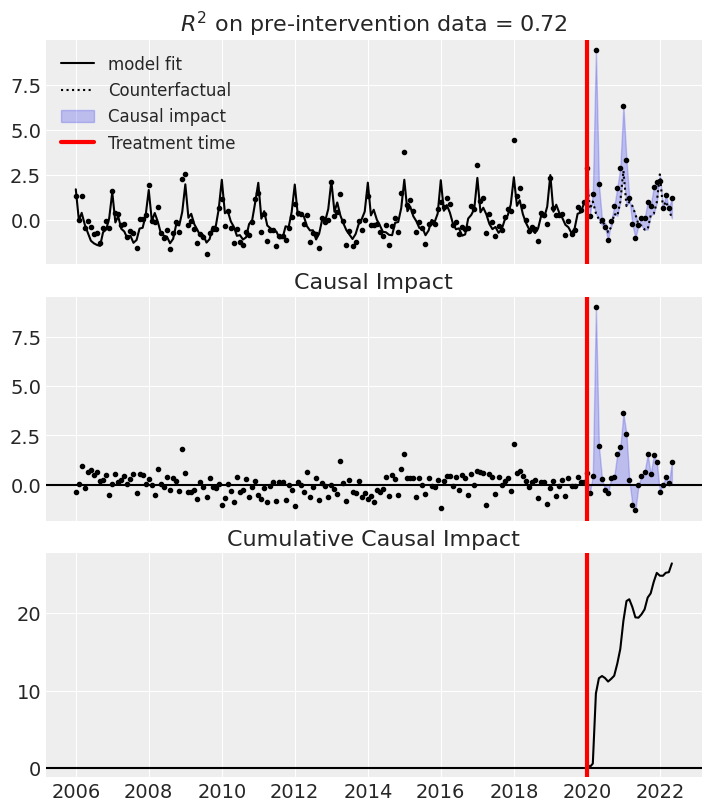

In [7]:
fig, ax = result.plot();

In [10]:
plt.savefig(
    image_path + "interrupted_time_series_skl.svg",
    bbox_inches="tight",
    pad_inches=0.1,
);

<Figure size 720x480 with 0 Axes>